In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callback.tracker import SaveModelCallback
import os
#from sklearn.model_selection import KFold
from torch.optim import RAdam
#from csvlogger import *
from torch.nn import Mish
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

fastai.__version__

'2.7.9'

In [2]:
sz = 128
bs = 4
nfolds = 4
SEED = 2022
N = 12 #number of tiles per image

## Dataframe

In [3]:
#|export
from ml.nb_03_dataset import *

In [4]:
from fastai.data.core import DataLoaders

In [5]:
from fastai.vision.all import *

In [6]:
import seaborn as sns
import numpy as np

In [46]:
df = pd.read_pickle("data/df_all_2022_10_06.pkl")
df.shape

(1180, 95)

In [47]:
df.loc[df["G"]=="2", "G"] = 2
df = df.loc[df["G"]!="1,2"]
print(df.shape)

(1177, 95)


In [48]:
df.G.value_counts()

2    982
1    126
3     69
Name: G, dtype: int64

In [49]:
df = df.sample(n = 1000)

In [50]:
df.shape

(1000, 95)

In [51]:
df = df.reset_index()

## Data

In [52]:
path = "/media/dimi/TOSHIBA EXT/Dimitrij Original Images/"

In [53]:
df["fn_x"]

0       /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA29_correctNames_SingleCores/6-G.tif
1       /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA03_correctNames_SingleCores/7-H.tif
2       /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA05_correctNames_SingleCores/8-A.tif
3       /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/2-D.tif
4      /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA06_correctNames_SingleCores/12-A.tif
                                                 ...                                           
995    /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA26_correctNames_SingleCores/13-H.tif
996     /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/5-A.tif
997     /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA06_correctNames_SingleCores/7-C.tif
998     /media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA06_correctNames_SingleCores/2-B.tif
999     /media/dimi/TOSHIBA EXT/Dimitrij

In [54]:
def get_image_files_from_df(path):
    fns = get_image_files(path)
    return [str(fn) for fn in fns if fn in df["fn_x"].tolist()]

In [55]:
correct_fns = get_image_files_from_df(path)

In [56]:
def get_correct_image_files(path):
    return correct_fns

In [57]:
def get_label(f):
    if f in correct_fns:
        return df.loc[df["fn_x"].astype(str)==f,"G"].iloc[0]
    else: return 0

In [58]:
f = get_image_files_from_df(path)[6]

In [59]:
fns= get_image_files(path)

In [60]:
get_label(f)

2

In [61]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_correct_image_files, 
                 get_y=get_label,
                 splitter=RandomSplitter(),
                 item_tfms=Resize(256))

In [62]:
dls = db.dataloaders(path)

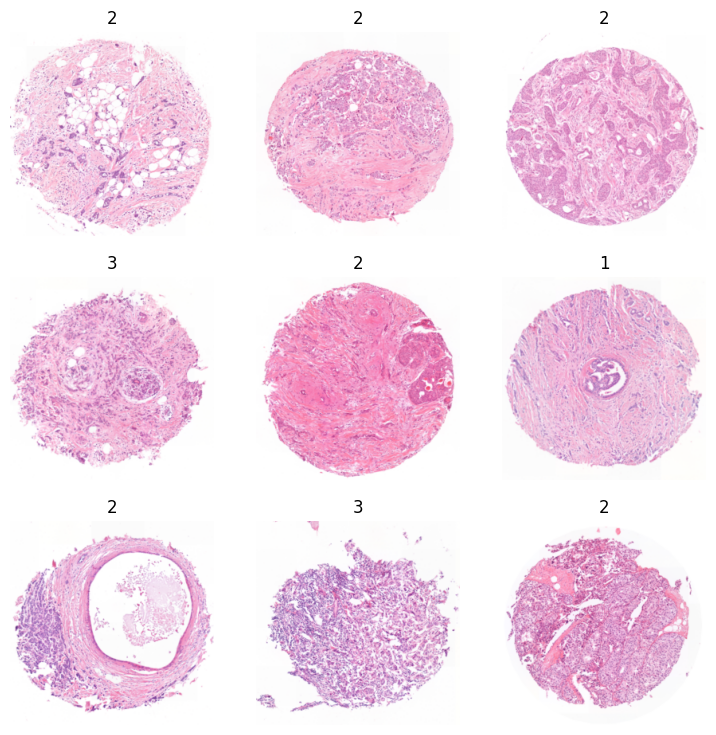

In [217]:
dls.show_batch()

In [24]:
from fastai.metrics import *
from fastai.vision import *
import fastai

In [25]:
from sklearn.metrics import cohen_kappa_score

In [63]:
kappa = skm_to_fastai(cohen_kappa_score)

In [65]:
#learn = vision_learner(dls, resnet18, metrics=kappa)
#learn.fine_tune(4)

In [67]:
#| export
def split_df(df, η=0.8 # percentage training
            ):
    msk = np.random.rand(len(df)) < η
    return df[msk], df[~msk]

In [72]:
df_tv, df_valid = split_df(df)
df_train, df_test = split_df(df_tv)

In [73]:
df_train.shape, df_valid.shape, df_test.shape

((643, 96), (201, 96), (156, 96))

In [74]:
ds_train = PatchedDataSet(p_outx, df_train, "G", "stime_10y_dom", 12, mean_img, std_img)
ds_valid = PatchedDataSet(p_outx, df_valid, "G", "stime_10y_dom", 12, mean_img, std_img)

In [91]:
dls = DataLoaders.from_dsets(ds_train, ds_valid, bs=1).cuda()

In [94]:
from torch.nn import CrossEntropyLoss

In [97]:
dls.c = 3

In [98]:
learn = vision_learner(dls, resnet18, metrics=kappa, loss_func=CrossEntropyLoss)

In [99]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,cohen_kappa_score,time


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 12, 3, 128, 128]

In [89]:
 DataLoaders.from_dsets??